# Analysis of the Global Innovation Index (GII) by WIPO

Summary: https://www.wipo.int/web-publications/global-innovation-index-2024/en/index.html  
Dataset: https://www.wipo.int/publications/de/details.jsp?id=4756&plang=DE


## Download & Preprocess Data

In [121]:
import sklearn
import numpy as np
from sklearn.svm import LinearSVR
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer


from sklearn.feature_selection import SelectFromModel

In [97]:
import wget
import os.path
import pandas as pd

filename = "../data/GII_2024.xlsx"
if not os.path.isfile(filename):
    url = "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2024-tech1.xlsx"
    filename = wget.download(url, out=filename)

dfs_2024 = pd.read_excel(filename, sheet_name=None)



In [98]:
def download(filename, url):
    if not os.path.isfile(filename):
        filename = wget.download(url, out=filename)

filename_2023 = "../data/GII_2023.xlsx"
filename_2022 = "../data/GII_2022.xlsx"
filename_2021 = "../data/GII_2021.xlsx"

download(filename_2023, "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2023-tech1.xlsx")
download(filename_2022, "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2022-tech1.xlsx")
download(filename_2021, "https://www.wipo.int/edocs/pubdocs/en/wipo_pub_2000-tech1.xlsx")

dfs_2023 = pd.read_excel(filename_2023, sheet_name=None)
dfs_2022 = pd.read_excel(filename_2022, sheet_name=None)
dfs_2021 = pd.read_excel(filename_2021, sheet_name=None)

In [99]:
def get_europe(in_df, data_name = "Data", economies_name = "Economies", iso_name = "ISO3", economy_name_name = "ECONOMY_NAME", 
               reguncode_name = "REG_UN_CODE", regun_name = "REG_UN"):
   
    gii_data = in_df[data_name]
    #display(gii_data)
    gii_economies = in_df[economies_name]
    #display(gii_economies)

    joined = gii_data.merge(gii_economies, on=iso_name, suffixes=["", "_joined_r"]).drop(columns=economy_name_name + "_joined_r")
    #display(joined)

    gii_data_eu = joined[joined[reguncode_name] == "EUR"].drop(columns=[regun_name, reguncode_name])
    #display(gii_data_eu)
    return gii_data_eu

    
    
    

In [100]:
dfs = dfs_2024

In [101]:
#gii_data_eu = get_europe(dfs_2021, "GII 2021 Data", "Economies in Context", "ISO2", "Economy", reguncode_name="RegionUNcode", regun_name="RegionUN")

In [102]:
for year in [2022, 2023, 2024]:
    dfs = globals()["dfs_" + str(year)]
    gii_data_eu = get_europe(dfs)
    globals()["gii_data_eu_" + str(year)] = gii_data_eu

In [103]:
gii_data_eu = (get_europe(dfs))

EU countries sorted by innovation level

In [104]:
def get_display_data():
    pure_rank = gii_data_eu[gii_data_eu["NUM"].isnull()]
    display_data = pure_rank.sort_values("RANK")[["RANK", "ECONOMY_NAME", "SCORE"]]
    display_data.rename(columns={"RANK": "GLOBAL_RANK"}, inplace=True)
    display_data.index = range(1, len(display_data) + 1)
    return display_data

display_data = get_display_data()

display(display_data)

,GLOBAL_RANK,ECONOMY_NAME,SCORE
1,1.0,Switzerland,67.473082
2,2.0,Sweden,64.524365
3,5.0,United Kingdom,61.049318
4,7.0,Finland,59.436931
5,8.0,Netherlands (Kingdom of the),58.833036
6,9.0,Germany,58.082837
7,10.0,Denmark,57.114019
8,12.0,France,55.413323
9,16.0,Estonia,52.307935
10,17.0,Austria,50.276568


Get all the scores in a nice format

In [105]:
def get_nice_table(gii_data_eu):
    gii_data_eu["NUM"] = gii_data_eu["NUM"].fillna("Final")
    df_scores = gii_data_eu.pivot_table(index='ECONOMY_NAME', columns='NUM', values='SCORE')
    df_scores.head()
    return gii_data_eu, df_scores

gii_data_eu, df_scores = get_nice_table(gii_data_eu)
#df_scores.head()

Check for NaNs

In [106]:
print(len(df_scores))
nans = df_scores.isna().sum()
nans[nans > 5]

39


NUM
IN.1.3.2      8
IN.2.1.2      6
IN.4.1.1      8
IN.4.1.3     28
IN.4.2.1     13
IN.4.2.2      6
OUT.6.1.3    15
OUT.7.1.1     7
OUT.7.2.3    18
dtype: int64

Keep only raw values

In [107]:
def get_raw_data_index_structure():
    gii_index_structure = dfs["Index Structure"]
    gii_index_structure = gii_index_structure.set_index("NUM")

    indicators = gii_index_structure[gii_index_structure["LEVEL"] == "Indicator"].index.tolist()

    df_scores_raw = df_scores[indicators]
    df_scores_raw.head()
    return df_scores_raw, gii_index_structure

df_scores_raw, gii_index_structure = get_raw_data_index_structure()

## Plots

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

### Correlation

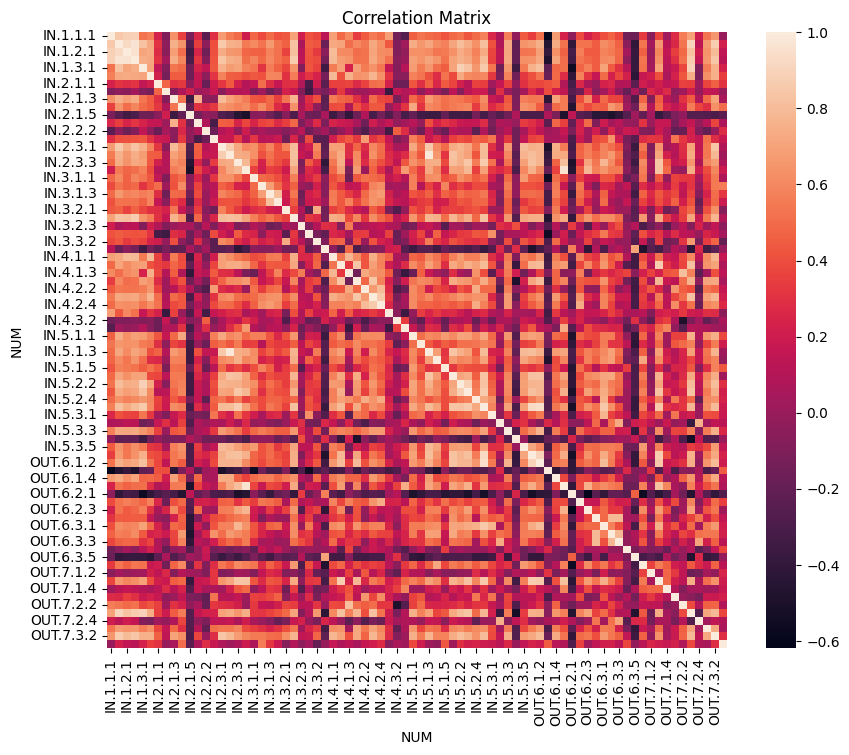

In [109]:
def get_corr_matrix(df_scores_raw):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_scores_raw.corr(),)
    plt.title("Correlation Matrix")
    plt.show()

get_corr_matrix(df_scores_raw)

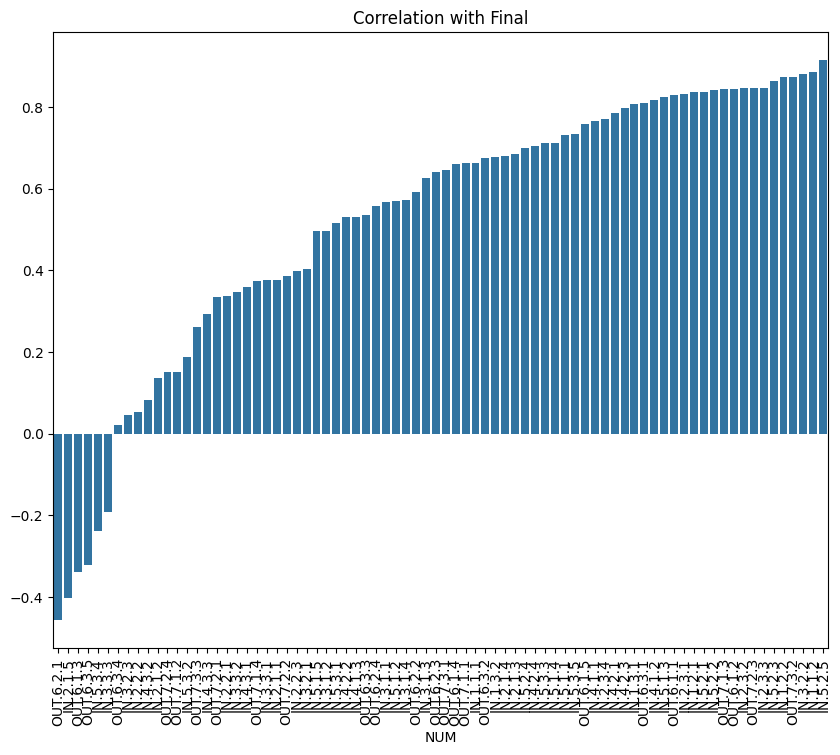

,NAME,DESCRIPTION,corr_w_final
NUM,,,
IN.1.1.2,Government effectiveness*,Index that reflects perceptions of the quality...,0.884958
IN.3.2.2,Logistics performance*,A multidimensional assessment of logistics per...,0.881405
OUT.7.3.2,GitHub commits/mn pop. 15–69,GitHub is the world’s largest host of source c...,0.874284
IN.1.2.2,Rule of law*,Index that reflects perceptions of the extent ...,0.873435
IN.5.2.3,State of cluster development†,Average answer to the survey question: In your...,0.862144
IN.2.3.3,"Global corporate R&D investors, top 3, mn USD",Average expenditure on R&D of the top three gl...,0.846993
OUT.7.2.3,Entertainment and media market/th pop. 15–69,'The Global Telecom and Entertainment & Media ...,0.846177
IN.2.3.2,"Gross expenditure on R&D, % GDP",Gross expenditure on R&D (GERD) is the total d...,0.845228
OUT.6.1.2,PCT patents by origin/bn PPP$ GDP,A PCT application refers to an international p...,0.844857


In [110]:
def get_correlation_final(df_scores_raw, df_scores):
    corr_with_final = df_scores_raw.corrwith(df_scores["Final"])

    plt.figure(figsize=(10, 8))
    g = sns.barplot(corr_with_final.sort_values(),)
    g.tick_params(axis='x', rotation=90)
    plt.title("Correlation with Final")
    plt.show()
    corr_top10 = abs(corr_with_final).sort_values(ascending=False).iloc[1:11]

    corr_top10_info = gii_index_structure.loc[corr_top10.index.to_list()][["NAME", "DESCRIPTION"]]
    corr_top10_info["corr_w_final"] = corr_top10
    display(corr_top10_info)

get_correlation_final(df_scores_raw, df_scores)

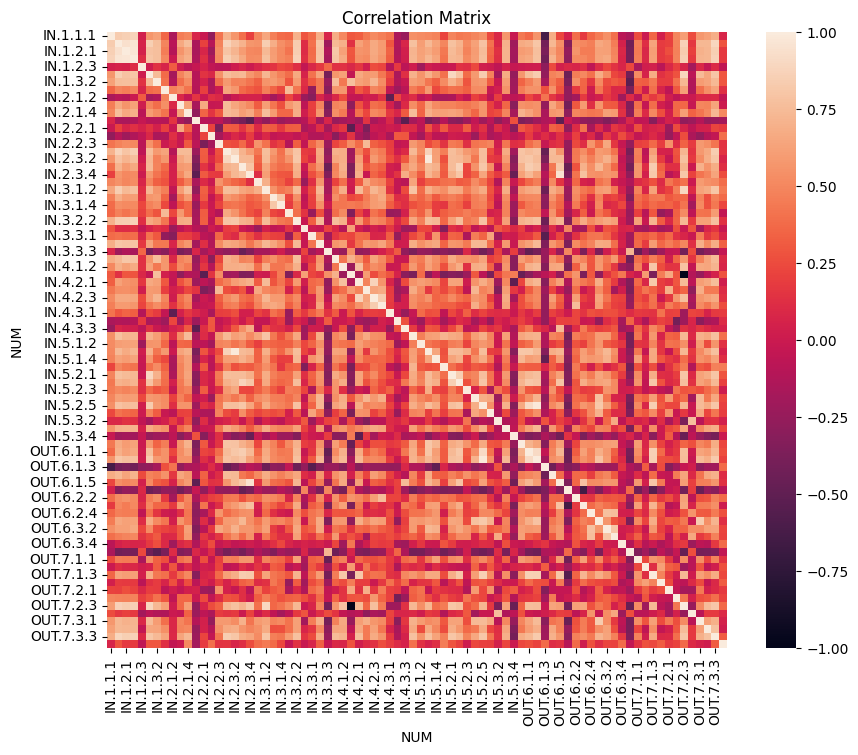

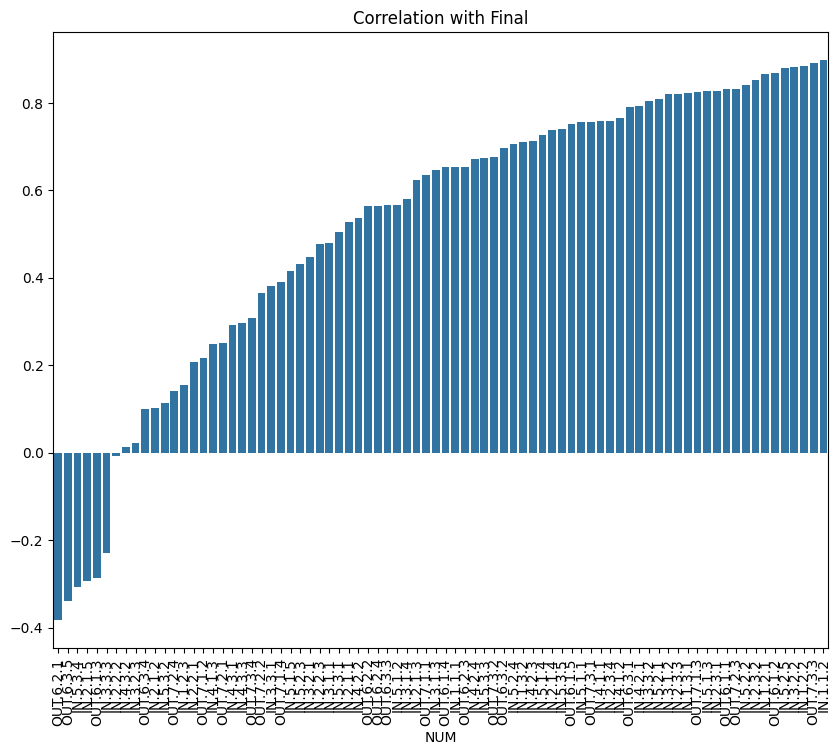

,NAME,DESCRIPTION,corr_w_final
NUM,,,
OUT.7.3.3,GitHub commits/mn pop. 15-69,GitHub is the worldâ€™s largest host of source...,0.890984
IN.1.2.2,Rule of law,Index that reflects perceptions of the extent ...,0.885219
IN.3.2.2,Logistics performance,A multidimensional assessment of logistics per...,0.881330
IN.5.2.5,Patent families/bn PPP$ GDP,A patent family is a set of interrelated paten...,0.879816
OUT.6.1.2,PCT patents by origin/bn PPP$ GDP,A PCT application refers to an international p...,0.868528
IN.1.2.1,Regulatory quality,Index that reflects perceptions of the ability...,0.866366
IN.2.3.2,"Gross expenditure on R&D, % GDP",Gross expenditure on R&D (GERD) is the total d...,0.852385
IN.5.2.2,State of cluster development,Average answer to the survey question: In your...,0.840780
OUT.7.2.3,Entertainment and media market/th pop. 15-69,The Global Entertainment & Media Outlook is a ...,0.832753


In [111]:
dfs = dfs_2023
gii_data_eu = get_europe(dfs)

gii_data_eu, df_scores = get_nice_table(gii_data_eu)
df_scores_raw, gii_index_structure = get_raw_data_index_structure()
get_corr_matrix(df_scores_raw)
get_correlation_final(df_scores_raw, df_scores)

## Predictors

### Finding predictors for future innovation level

In [122]:

def get_importances(df_scores, df_scores_raw):
    y = df_scores["Final"]
#X = df_scores_raw.drop(columns="Final")
    X = df_scores_raw
#X.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    if np.isnan(X_imputed).any():
        raise ValueError("There are still NaN values in X_imputed after imputation")
    pd.DataFrame(X_imputed).isna().any().sum()

    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_imputed,y)
    importances = reg.feature_importances_
    importances_df = pd.DataFrame(importances, index=X.columns, columns=["Importance"])
    importances_df.head()
    return importances_df
get_importances()


TypeError: get_importances() missing 2 required positional arguments: 'df_scores' and 'df_scores_raw'

In [ ]:
importances_df = get_importances

,Importance
NUM,
IN.1.1.1,0.000782
IN.1.1.2,0.008640
IN.1.2.1,0.025364
IN.1.2.2,0.069525
IN.1.2.3,0.000000


<Axes: xlabel='NUM'>

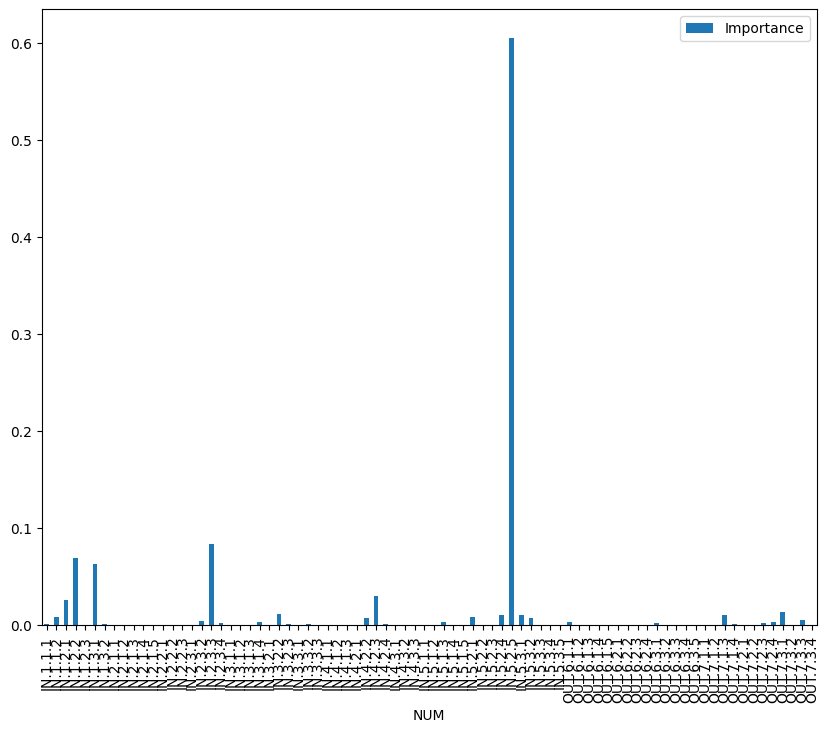

In [118]:
importances_df.plot(kind='bar', figsize=(10, 8))

In [119]:

lsvc = LinearSVR(C=0.01).fit(X_imputed, y)

model = SelectFromModel(lsvc, prefit=True)

model.get_support(True)

h:\tuwien\dopp\ex2\DOPP_WS24\.venv\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([ 2,  3,  4, 13, 14, 15, 17, 21, 22, 24, 28, 29, 31, 34, 40, 43, 48,
       49, 54, 55, 57, 58, 61, 62, 64, 65, 68, 69, 70, 71, 72, 74, 76, 78])

In [120]:
from sklearn.ensemble import ExtraTreesClassifier